# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import pathlib
import random
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, GaussianNoise, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomContrast, RandomRotation, RandomCrop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Pre-configuration

In [2]:
batch_size = 32
input_size = 224
model_name = "resnet50"  # Change this to "resnet50" or "efficientnetb0" to use other models
initial_epochs = 10
base_learning_rate = 0.001


# Define a function to get the base model, preprocess input function, and model type based on the model name

In [3]:
def get_base_model(model_name):
    if model_name == "mobilenet_V2":
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        model_type = tf.keras.applications.MobileNetV2
    elif model_name == "resnet50":
        preprocess_input = tf.keras.applications.resnet.preprocess_input
        model_type = tf.keras.applications.ResNet50
    elif model_name == "efficientnetb0":
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        model_type = tf.keras.applications.EfficientNetB0
    else:
        raise ValueError("Invalid model name")

    return preprocess_input, model_type

In [4]:
preprocess_input, model_type = get_base_model(model_name)

# Data preparation

In [5]:
train_dir = 'Training Image sp 23'
validation_dir = test_dir = 'Test Image sp 23'

BATCH_SIZE = batch_size
IMG_SIZE = (input_size, input_size)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True, 
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

class_names = train_dataset.class_names
print("Class names: ", class_names)
num_classes = len(class_names)
print("Class count: ", num_classes)

Found 1838 files belonging to 16 classes.
Found 480 files belonging to 16 classes.
Found 480 files belonging to 16 classes.
Class names:  ['Adult', 'Airplane', 'Alpaca', 'Bird', 'Bus', 'Car', 'Cat', 'Child', 'Elephant', 'Flower', 'Giraffe', 'Horse', 'Monkey', 'Panda', 'Reptile', 'Vessel']
Class count:  16


# Data Preprocessing

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = Sequential([
  RandomFlip('horizontal_and_vertical',input_shape=(IMG_SIZE[0],IMG_SIZE[1],3)),
  RandomContrast(1),
  RandomRotation((-1, 0.5)),
  RandomCrop(224,224),
  GaussianNoise(0.2)
])

IMG_SHAPE = IMG_SIZE + (3,)
base_model = model_type(input_shape=IMG_SHAPE,
                        include_top=False,
                        weights='imagenet')

# See how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

base_model.trainable = True
# Re-train last 5 layers
fine_tune_at = len(base_model.layers) - 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  175


# Build and train model

In [7]:
inputs = Input(shape=IMG_SHAPE, name='image_tensor')

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

# 1 additional Dense layer
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)

x = Dense(num_classes)(x)
outputs = Activation('softmax', name='predict')(x)

model = Model(inputs, outputs, name=model_name)

model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()
print(f"Number of trainable variables: {len(model.trainable_variables)}")

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_tensor (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                   

/Users/admin/miniconda3/envs/ai_report/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2023-05-01 19:03:18.249586: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - 15s 946ms/step - loss: 3.5971 - accuracy: 0.0833
initial loss: 3.60
initial accuracy: 0.08


In [8]:
early_stop_callback = EarlyStopping(patience=5, monitor='val_accuracy', mode='max')
best_model_path = 'model_resnet50.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
    model_checkpoint_callback,
    early_stop_callback
]

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    # epochs=5,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

# Load the best model
best_model = tf.keras.models.load_model(best_model_path)

Epoch 1/10
58/58 [==============================] - 75s 1s/step - loss: 1.5282 - accuracy: 0.6039 - val_loss: 0.5989 - val_accuracy: 0.8875
Epoch 2/10
58/58 [==============================] - 72s 1s/step - loss: 0.8897 - accuracy: 0.7927 - val_loss: 0.4729 - val_accuracy: 0.9250
Epoch 3/10
58/58 [==============================] - 72s 1s/step - loss: 0.7046 - accuracy: 0.8417 - val_loss: 0.4743 - val_accuracy: 0.9312
Epoch 4/10
58/58 [==============================] - 71s 1s/step - loss: 0.6594 - accuracy: 0.8558 - val_loss: 0.4584 - val_accuracy: 0.9250
Epoch 5/10
58/58 [==============================] - 73s 1s/step - loss: 0.6572 - accuracy: 0.8417 - val_loss: 0.4732 - val_accuracy: 0.9312
Epoch 6/10
58/58 [==============================] - 72s 1s/step - loss: 0.6121 - accuracy: 0.8624 - val_loss: 0.3955 - val_accuracy: 0.9500
Epoch 7/10
58/58 [==============================] - 72s 1s/step - loss: 0.6263 - accuracy: 0.8520 - val_loss: 0.4321 - val_accuracy: 0.9438
Epoch 8/10
58/58 [==

# Show results

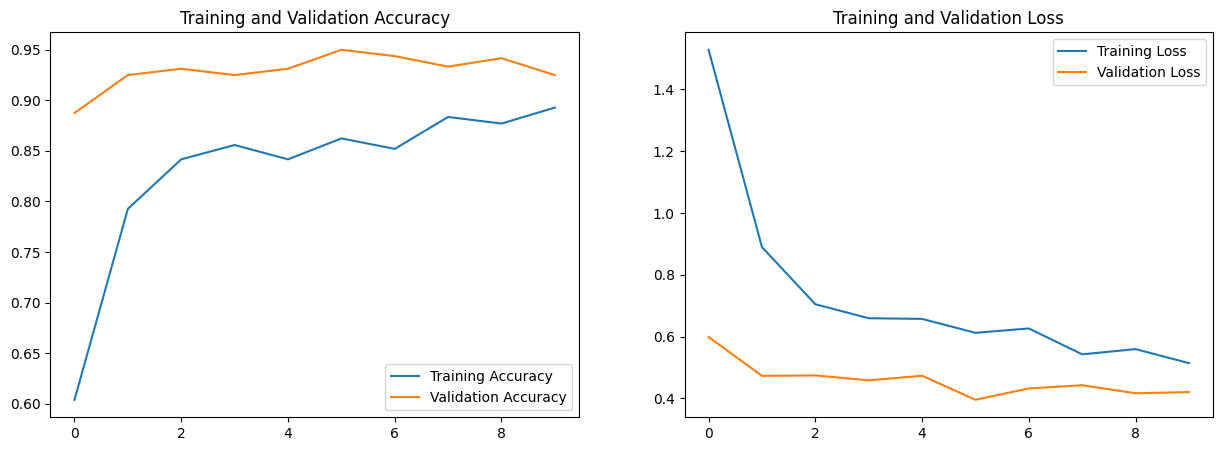

In [9]:
# Plot accuracy and loss over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}".format(test_accuracy))

15/15 [==============================] - 14s 929ms/step - loss: 0.4195 - accuracy: 0.9271
Test loss: 0.42
Test accuracy: 0.93


In [11]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}".format(test_accuracy))

# Print confusion matrix and classification report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    pred_labels = np.argmax(predictions, axis=-1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

cr = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(cr)

15/15 [==============================] - 14s 932ms/step - loss: 0.4227 - accuracy: 0.9208
Test loss: 0.42
Test accuracy: 0.92
1/1 [==============================] - 1s 936ms/step
Confusion Matrix:
[[28  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0 29  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 28  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0]
 [16  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0]
 [ 2  0  0  1  0  0  1  0  0 25  0  0  1  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0 28  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  1  1  0  0 26  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0 28  0  0  0]
 [ 0  0  0  1  0  0  0  1  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 

Predictions:
 [ 2  5  0  8  4  0 11 13 14  6  6  9 15  3  0 10 11  8  1  3  3  2  9 11
 15  8 15  1  9  6  5  8]
Labels:
 [ 2  5  7  8  4  0 11 13 14  6  6  9 15  3  7 10 11  8  1  3  3  2  9 11
 15  8 15  1  9  6  5  8]


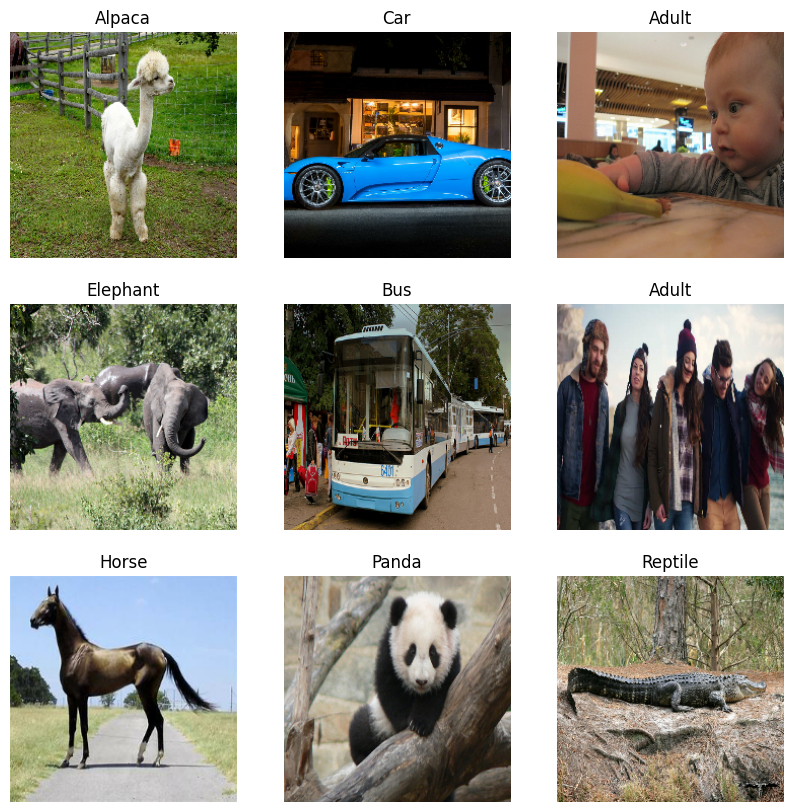

In [12]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a softmax function to get probabilities for each class
predictions = tf.nn.softmax(predictions, axis=-1)
predicted_labels = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_labels.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_labels[i]])
    plt.axis("off")


# Modify the output sample file and save it to a .csv file

In [13]:
test_data_root = pathlib.Path(test_dir)
all_test_image_paths = list(test_data_root.glob('*/*'))

# Create a dictionary to map class names to numbers
class_name_to_number = {class_name: i + 1 for i, class_name in enumerate(class_names)}

# Read the CSV file into a DataFrame
df = pd.read_csv("image_sample_output.csv")

# Loop through the rows of the DataFrame
for index, row in df.iterrows():
    image_id = row["Id"]
    
    # Find the index of the image in the all_test_image_paths list
    image_path = [path for path in all_test_image_paths if os.path.splitext(os.path.basename(path))[0] == image_id][0]
    
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    img_array = preprocess_input(img_array)

    # Make a prediction using the model
    prediction = model.predict(img_array)
    predicted_label_index = np.argmax(prediction, axis=-1)
    predicted_class_name = class_names[predicted_label_index[0]]

    # Update the second column (label) with the predicted label
    df.loc[index, "Class"] = class_name_to_number[predicted_class_name]

# Save the DataFrame with predicted labels back to the CSV file
df.to_csv("project_image_nghianguyen_resnet50.csv", index=False)

1/1 [==============================] - 0s 61ms/step
